In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_local("../../PtDAlgorithms")
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# %%R
# pkgbuild::check_build_tools(debug = TRUE)

In [4]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [5]:
plot_graph <- function(gam, constrained=TRUE, size=c(6, 6), fontsize=10, rankdir="LR") {

    if (constrained) {
        constrained <- 'true'
    } else {
        constrained <- 'false'
    }

    edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false];'
    start_name <- 'IPV'
    absorbing_name <- 'Absorb'
    edges <- c()
    for (i in 1:length(gam$IPV)) {
        if (gam$IPV[i] > 0) {
            edge <- edge_templ
            edge <- sub('FROM', start_name, edge)
            edge <- sub('TO', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('LABEL', gam$SIM[i, 1], edge)
            edges <- c(edges, edge)
        }
    }    
    for (i in 1:nrow(gam$states)) {
        for (j in 1:nrow(gam$states)) {
            if ((i != j) && (gam$SIM[i, j] > 0)) {
                edge <- edge_templ
                edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
                edge <- sub('TO', paste(gam$states[j,], collapse = ","), edge)
                edge <- sub('LABEL', gam$SIM[i, j], edge)
                edges <- c(edges, edge)
            }
        }
    }
    absorb_rates <- -rowSums(gam$SIM)
    for (i in 1:nrow(gam$states)) {
        if (absorb_rates[i] > 0) {
            # edges <- c(edges, paste('"', from, '"', ' -> ', 'Absorb', '[constraint=true, label="', label, '",labelfloat=false]', ';', sep='')) 
            edge <- edge_templ
            edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('TO', absorbing_name, edge)
            edge <- sub('LABEL', absorb_rates[i], edge)
            edges <- c(edges, edge)
        }
    }
    graph_spec <- paste(edges, sep='\n', collapse = '')
    style_str <- '
        rankdir=RANKDIR;
        size="SIZEX,SIZEY";
        fontname="Helvetica,Arial,sans-serif"
    	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
    	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
        Absorb [style=filled,color="lightgrey"]
        IPV [style=filled,color="lightgrey"]
    '
    style_str <- sub('SIZEX', size[1], style_str)
    style_str <- sub('SIZEY', size[2], style_str)
    style_str <- gsub('FONTSIZE', fontsize, style_str)    
    style_str <- gsub('RANKDIR', rankdir, style_str)    
    graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
    system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
    return(display_svg(file="tmp.svg"))
    }

In [6]:
matrix_size <- 10
population <- 1
locus <- 1
i <- 9
j <- 9
(matrix_size * matrix_size * population) + i + j * matrix_size;

matrix_size**2 * (population + 2**locus) + i + j * matrix_size


[1] 199

[1] 399

# IM model

Each state has the following three properties:
1. nr decendants in population 1
2. nr decendants in population 2
3. what population the lineage is currently in

In [7]:
Rcpp::sourceCpp("./cpp/isolation_migration.cpp")

In [8]:
graph <- construct_im_graph(8,8,1,1,0.1,0.1)
vertices_length(graph)

[1] 480664

In [9]:
states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))

parents <- c()
children <- c()
rates <- c()
for (i in 1:vertices_length(graph)) {
    for (edge in edges(vertex_at(graph, i))) {
        parents <- c(parents, i)
        children <- c(children, edge$child$index)
        rates <- c(rates, edge$weight)
    }
}

Comparing results for numerical accuracy for an "infinite" IM stage

In [ ]:
n1 <- 4
n2 <- 4

g <- construct_im_graph(n1,n2,1,1,0.1,0.1)

expected_visits <- rep(0, vertices_length(g))
ctx <- distribution_context(g,1000)
while (distribution_context_state(ctx)$cdf < 0.9999) {
  distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)

distribution_expectation <- matrix(nrow=n1+1,ncol=n2+1)
algorithm_expectation <- matrix(nrow=n1+1,ncol=n2+1)
matrix_expectation <- matrix(nrow=n1+1,ncol=n2+1)
simulation_expectation <- matrix(nrow=n1+1,ncol=n2+1)
PH <- graph_as_matrix(g)
U <- solve(-PH$SIM)
set.seed(1234)

for (i in 0:n1) {
  for (j in 0:n2) {
    matrix_expectation[i+1,j+1] <-PH$IPV %*% U%*%diag(PH$states[,(matrix_index(i,j,0,n1,n2)+1)]+PH$states[,(matrix_index(i,j,1,n1,n2)+1)])%*%rep(1,length(PH$IPV))
    algorithm_expectation[i+1, j+1]<- expectation(g, rewards_at(g, i,j,n1,n2))
    distribution_expectation[i+1,j+1] <- sum(expected_visits * rewards_at(g, i,j,n1,n2))
    simulation_expectation[i+1, j+1]<- mean(rph(1000000, g, rewards_at(g, i,j,n1,n2)))
  }
}

print(sum(abs(matrix_expectation - algorithm_expectation)))
print(sum(abs(matrix_expectation - simulation_expectation)))
print(sum(abs(matrix_expectation - distribution_expectation)))

In [ ]:
df <- as.data.frame(matrix_expectation)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    scale_y_discrete(labels= seq(1, nrow(matrix_expectation))) + 
    scale_fill_continuous(type = "viridis") + 
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

The complete IM model with a split time and ancestral population:

In [ ]:
# parameters
n1 <- 4
n2 <- 4
m1 <- 1
m2 <- 1
split_t <- 1.5 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1,n2,1,1,0.1,0.1)
cat(vertices_length(im_g), "\n")

# create ancestral graph
a_g <- construct_ancestral_graph(n1,n2,1)
cat(vertices_length(a_g), "\n")


# Compute the IM matrix

In [9]:
start <- proc.time()[3]            

# parameters
n1 <- 7
n2 <- 7
m12 <- 1
m21 <- 1
p1 <- 1
p2 <- 1
pa <- 1
split_t <- 1.5 # time in whatever unit used to scale transition probs (N generations)

# build im graph
im_g <- construct_im_graph(n1, n2, p1, p2, m12, m21)
cat(vertices_length(im_g), "\n")

im_expected_visits <- accumulated_visiting_time(im_g, split_t)

#print(im_expected_visits)

# create ancestral graph
a_g <- construct_ancestral_graph(n1, n2, pa)
cat(vertices_length(a_g), "\n")

# find probabilities of starting at each state in ancestral graph
start_prob <- start_prob_from_im(a_g, im_g, im_expected_visits)

# compute expectations for each graph
im_expectation <- matrix(nrow=n1+1,ncol=n2+1)
a_expectation <- matrix(nrow=n1+1,ncol=n2+1)
for (i in 0:n1) {
  for (j in 0:n2) {
    im_expectation[i+1,j+1] <- sum(im_expected_visits * rewards_at(im_g, i,j,n1,n2))
    a_expectation[i+1, j+1]<- sum(start_prob * expected_waiting_time(a_g, rewards_at(a_g, i,j,n1,n2)))
  }
}
proc.time()[3]-start

123135 
2999 


elapsed 
 10.905

In [10]:
# ## pd.DataFrame(im_expectation).to_hdf(f'im_{int(n1)}_{int(n2)}_{float(m1)}_{float(m2)}_{float(split_t)}.h5', key='df', format='table')
# pd.DataFrame(a_expectation).to_hdf(f'a_{int(n1)}_{int(n2)}.h5', key='df', format='table')

Expectation for inifinte IM stage:

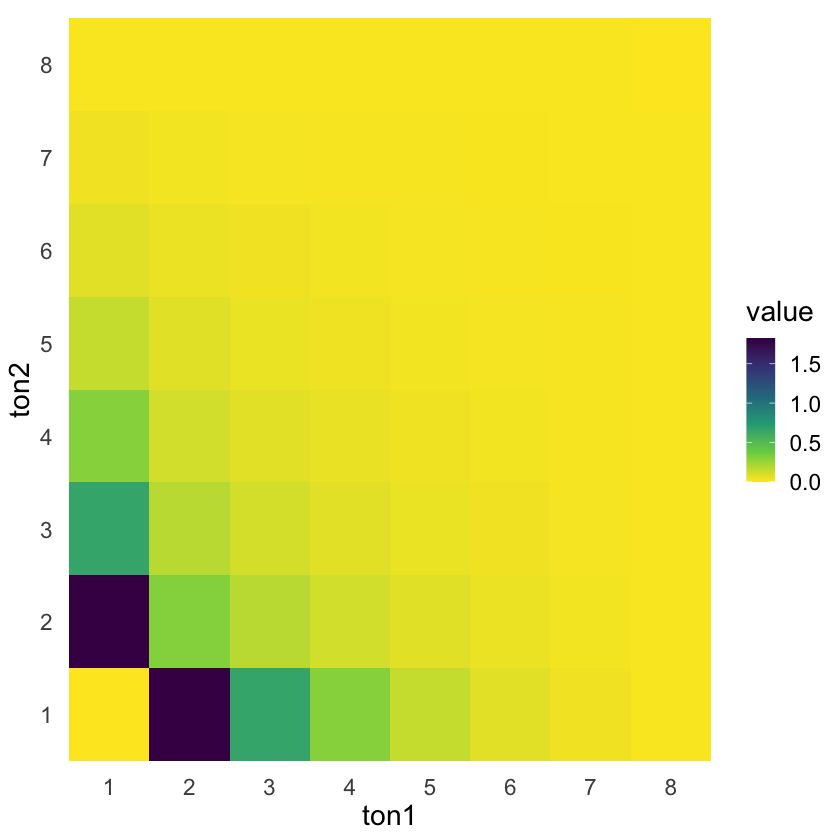

In [11]:
df <- as.data.frame(im_expectation)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
df$ton1 <- as.numeric(df$ton1)
df$ton2 <- as.numeric(substring(df$ton2, 2))
#print( (df$ton2)[order(substr(df$ton))] )
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    scale_y_discrete(limits=factor(seq(1, nrow(im_expectation)))) + 
    scale_x_discrete(limits=factor(seq(1, nrow(im_expectation)))) + 
    scale_fill_continuous(type="viridis", direction=-1) + 
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

Expectation for panmictic ancestral population:

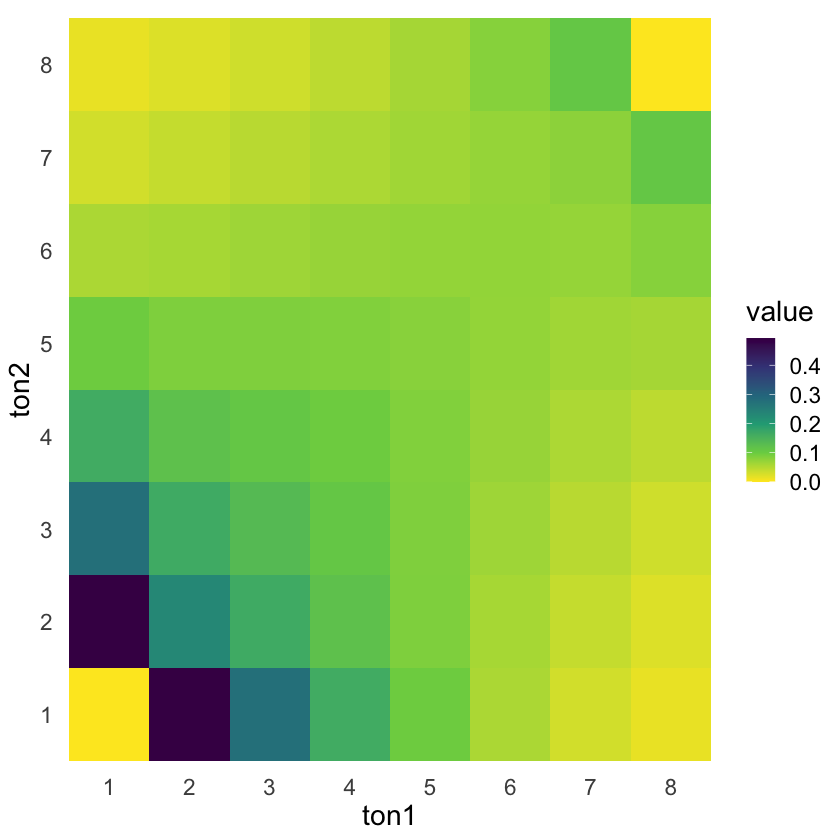

In [12]:
df <- as.data.frame(a_expectation)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
df$ton1 <- as.numeric(df$ton1)
df$ton2 <- as.numeric(substring(df$ton2, 2))
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    scale_y_discrete(limits=factor(seq(1, nrow(a_expectation)))) + 
    scale_x_discrete(limits=factor(seq(1, nrow(a_expectation)))) + 
    scale_fill_continuous(type="viridis", direction=-1) + 
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

Expectation for combined IM model with split time:

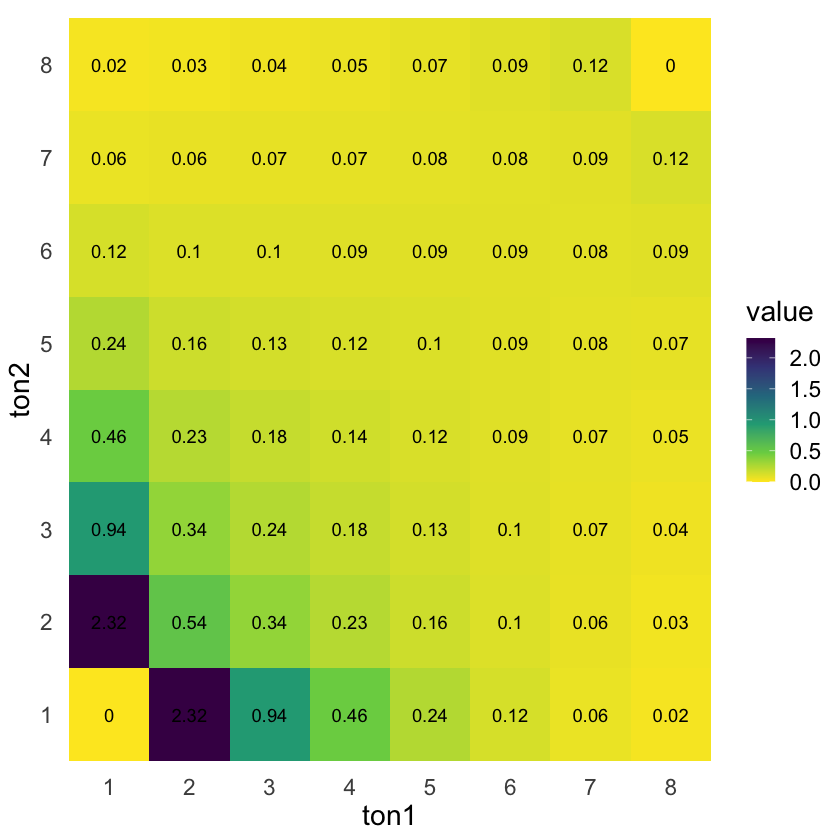

In [13]:
df <- as.data.frame(im_expectation + a_expectation)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
df$ton1 <- as.numeric(df$ton1)
df$ton2 <- as.numeric(substring(df$ton2, 2))
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 2))) +
    scale_y_discrete(limits=factor(seq(1, nrow(a_expectation)))) + 
    scale_x_discrete(limits=factor(seq(1, nrow(a_expectation)))) + 
    scale_fill_continuous(type="viridis", direction=-1) + 
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

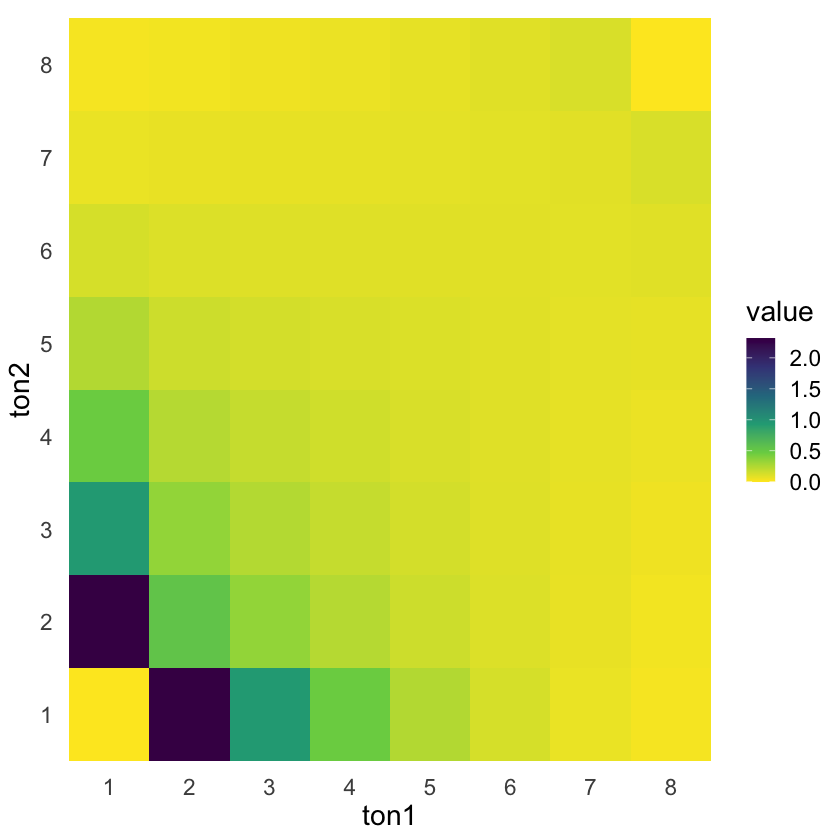

In [14]:
df <- as.data.frame(im_expectation + a_expectation)
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
df$ton1 <- as.numeric(df$ton1)
df$ton2 <- as.numeric(substring(df$ton2, 2))
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    scale_y_discrete(limits=factor(seq(1, nrow(a_expectation)))) + 
    scale_x_discrete(limits=factor(seq(1, nrow(a_expectation)))) +  
    scale_fill_continuous(type="viridis", direction=-1) + 
    theme_minimal() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 